In [4]:
import pandas as pd

observed_df=pd.read_csv('관측.csv')
forecast_df=pd.read_csv('예측.csv')

In [ ]:
forecast_df.isnull().sum()

In [ ]:
forecast_df

In [ ]:
observed_df

In [ ]:
import pandas as pd

observed_df=pd.read_csv('관측.csv')
forecast_df=pd.read_csv('예측.csv')

observed_df["기상관측일시"] = pd.to_datetime(observed_df["기상관측일시"])
forecast_df["기상관측일시"] = pd.to_datetime(forecast_df["기상관측일시"])

observed_df["대기압(hPa)"] = observed_df["대기압(mmHg)"]* 1.33322

merged_df = pd.merge(forecast_df, observed_df, on = "기상관측일시", suffixes = ("_예측", "_관측"))
merged_df = merged_df.sort_values("기상관측일시").reset_index(drop=True)

merged_df

In [ ]:
merged_df.isnull().sum()

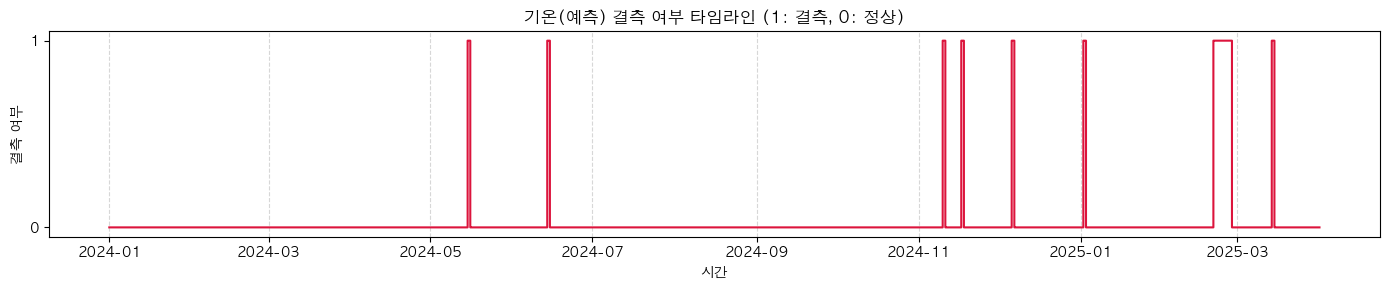

In [81]:
# 1시간 간격의 전체 시간 생성
time_index = pd.date_range(start=merged_df["기상관측일시"].min(),
                           end=merged_df["기상관측일시"].max(),
                           freq='H')

# 결측 여부 (1: 결측, 0: 정상)
missing_mask = merged_df.set_index("기상관측일시")["기온(degC)_예측"].isna()
missing_series = missing_mask.reindex(time_index, fill_value=False).astype(int)

# 시각화
plt.figure(figsize=(14, 3))
plt.plot(missing_series.index, missing_series.values, drawstyle='steps-mid', color='crimson')
plt.title("기온(예측) 결측 여부 타임라인 (1: 결측, 0: 정상)")
plt.xlabel("시간")
plt.ylabel("결측 여부")
plt.yticks([0, 1])
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [18]:
#결측치 간격 확인 (연속인지, 띄엄띄엄인지)
missing_idx = merged_df[merged_df["기온(degC)_예측"].isna()].index
diffs = missing_idx.to_series().diff().value_counts().sort_index()
print(diffs)


1.0       328
145.0       1
361.0       1
433.0       1
625.0       1
697.0       1
1153.0      1
3553.0      1
Name: count, dtype: int64


In [20]:
#기상관측일시 기준 시간대 분석
merged_df["hour"] = merged_df["기상관측일시"].dt.hour
merged_df[merged_df["기온(degC)_예측"].isna()]["hour"].value_counts().sort_index()


hour
0     14
1     14
2     14
3     14
4     14
5     14
6     14
7     14
8     14
9     14
10    14
11    14
12    14
13    14
14    14
15    14
16    14
17    14
18    14
19    14
20    14
21    14
22    14
23    14
Name: count, dtype: int64

In [ ]:
def find_consecutive_nan_ranges(series):
    """
    시리즈에서 연속된 NaN 구간의 (시작 인덱스, 끝 인덱스, 길이)를 찾아줌
    """
    is_nan = series.isna()
    nan_ranges = []
    start = None

    for i, val in enumerate(is_nan):
        if val and start is None:
            start = i
        elif not val and start is not None:
            end = i - 1
            if end > start:
                nan_ranges.append((start, end, end - start + 1))
            start = None
    # 마지막이 NaN으로 끝나는 경우
    if start is not None:
        nan_ranges.append((start, len(series)-1, len(series)-start))

    return nan_ranges

nan_ranges = find_consecutive_nan_ranges(merged_df["기온(degC)_예측"])

# 길이 순 정렬
nan_ranges = sorted(nan_ranges, key=lambda x: x[2], reverse=True)

print("연속 결측 구간 (시작 인덱스, 끝 인덱스, 길이):")
for r in nan_ranges:
    print(r)
# 가장 긴 구간 하나만 시각화
start_idx, end_idx, length = nan_ranges[0]
plot_df = merged_df.loc[start_idx - 48 : end_idx + 48]  # 앞뒤로 2일치 포함

plt.figure(figsize=(12, 5))
plt.plot(plot_df["기상관측일시"], plot_df["기온(degC)_예측"], label="예측", marker='o', linestyle='-')
plt.axvspan(
    plot_df.iloc[48]["기상관측일시"],
    plot_df.iloc[48 + length - 1]["기상관측일시"],
    color="red", alpha=0.3, label="결측 구간"
)
plt.title("기온(예측) 연속 결측 구간 시각화")
plt.xlabel("시간")
plt.ylabel("기온(예측)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from statsmodels.tsa.seasonal import STL

# 0. 데이터 불러오기 및 전처리
observed_df = pd.read_csv('관측.csv')
forecast_df = pd.read_csv('예측.csv')

observed_df["기상관측일시"] = pd.to_datetime(observed_df["기상관측일시"])
forecast_df["기상관측일시"] = pd.to_datetime(forecast_df["기상관측일시"])
observed_df["대기압(hPa)"] = observed_df["대기압(mmHg)"] * 1.33322
observed_df.drop(columns=["대기압(mmHg)"], inplace=True)

merged_df = pd.merge(forecast_df, observed_df, on="기상관측일시", suffixes=("_예측", "_관측"))
merged_df = merged_df.sort_values("기상관측일시").reset_index(drop=True)

# 1. KNN 보간 함수 정의
def knn_impute_all_numeric(df, numeric_cols, n_neighbors=3):
    df = df.copy()
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[numeric_cols])
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
    imputed_scaled = imputer.fit_transform(scaled)
    df[numeric_cols] = scaler.inverse_transform(imputed_scaled)
    if "절대습도" in df.columns:
        df["절대습도"] = df["절대습도"].clip(lower=0)
    if "일사량(w/m^2)" in df.columns:
        df["일사량(w/m^2)"] = df["일사량(w/m^2)"].clip(lower=0)
    return df

def fill_forecast_stl(df, colname, period=24):
    series = df[colname]
    stl = STL(series, period=period, robust=True)
    res = stl.fit()
    expected = res.trend + res.seasonal
    filled = series.copy()
    filled[series.isna()] = expected[series.isna()]
    return filled

# 2. KNN 보간 수행
numeric_cols = [
    "기온(degC)_예측", "습도(%)_예측", "대기압(hPa)_예측",
    "절대습도", "일사량(w/m^2)"
]

merged_df = merged_df.set_index("기상관측일시").sort_index()
merged_df["습도(%)_예측"] = fill_forecast_stl(merged_df, "습도(%)_예측", period=24)
merged_df = merged_df.reset_index()
knn_cols = [col for col in numeric_cols if col != "습도(%)_예측"]
merged_df = knn_impute_all_numeric(merged_df, knn_cols)

merged_df["hour"] = merged_df["기상관측일시"].dt.hour
merged_df.loc[merged_df["hour"].isin([0,1,2,3,4,5]), "일사량(w/m^2)"] = 0

T = merged_df["기온(degC)_예측"]
RH = merged_df["습도(%)_예측"]
merged_df["절대습도"] = 6.112 * np.exp((17.67 * T) / (T + 243.5)) * RH * 2.1674 / (273.15 + T)

# 3. 시간 정보 파생변수
merged_df["month"] = merged_df["기상관측일시"].dt.month
merged_df["dayofweek"] = merged_df["기상관측일시"].dt.dayofweek
merged_df["is_weekend"] = merged_df["dayofweek"].isin([5,6]).astype(int)
merged_df["is_night"] = merged_df["hour"].isin([0,1,2,3,4,5]).astype(int)

merged_df["기온_diff_t1"] = merged_df["기온(degC)_예측"].diff()
merged_df["습도_diff_t1"] = merged_df["습도(%)_예측"].diff()

merged_df["기온_rollmean_24"] = merged_df["기온(degC)_예측"].rolling(window=24, min_periods=1).mean()
merged_df["습도_rollstd_24"] = merged_df["습도(%)_예측"].rolling(window=24, min_periods=1).std()

merged_df["기온x습도"] = merged_df["기온(degC)_예측"] * merged_df["습도(%)_예측"]
merged_df["기온x대기압"] = merged_df["기온(degC)_예측"] * merged_df["대기압(hPa)_예측"]

# 4. 시계열 lag 피처 추가
for col in ["기온(degC)_예측", "습도(%)_예측", "절대습도"]:
    merged_df[f"{col}_t-1"] = merged_df[col].shift(1)
    merged_df[f"{col}_t-24"] = merged_df[col].shift(24)

# 5. Train/Test 분리 (2025년 3월 기준)
test_start = pd.to_datetime("2025-03-01 00:00:00")
test_end = pd.to_datetime("2025-03-31 23:00:00")

test_df = merged_df[(merged_df["기상관측일시"] >= test_start) & 
                    (merged_df["기상관측일시"] <= test_end)].copy()
train_df = merged_df[(merged_df["기상관측일시"] < test_start) |
                     (merged_df["기상관측일시"] > test_end)].copy()

# 6. 모델 학습 및 평가
target_cols = [
    ("기온(degC)_예측", "기온(degC)_관측"),
    ("습도(%)_예측", "습도(%)_관측"),
    ("대기압(hPa)_예측", "대기압(hPa)_관측")
]

feature_cols = [
    "기온(degC)_예측", "습도(%)_예측", "대기압(hPa)_예측",
    "절대습도", "일사량(w/m^2)", "hour", "month",
    "dayofweek", "is_weekend", "is_night",
    "기온(degC)_예측_t-1", "기온(degC)_예측_t-24",
    "습도(%)_예측_t-1", "습도(%)_예측_t-24",
    "절대습도_t-1", "절대습도_t-24",
    "기온_diff_t1", "습도_diff_t1",
    "기온_rollmean_24", "습도_rollstd_24",
    "기온x습도", "기온x대기압"
]

best_params_dict = {
    "기온(degC)_관측": {
        'n_estimators': 345, 'max_depth': 10,
        'learning_rate': 0.06366054573254167,
        'subsample': 0.6792236991472945,
        'colsample_bytree': 0.9433763219134894,
        'gamma': 0.06802837655107982,
        'min_child_weight': 6
    },
    "습도(%)_관측": {
        'n_estimators': 472, 'max_depth': 10,
        'learning_rate': 0.04088824800809916,
        'subsample': 0.6613050563545007,
        'colsample_bytree': 0.8895755595712794,
        'gamma': 0.6586505327305421,
        'min_child_weight': 2
    },
    "대기압(hPa)_관측": {
        'n_estimators': 206, 'max_depth': 10,
        'learning_rate': 0.0988168155328505,
        'subsample': 0.9600614217645739,
        'colsample_bytree': 0.9061626558584954,
        'gamma': 0.039912641615761635,
        'min_child_weight': 3
    }
}

predictions = {}
models = {}
y_true_dict = {}
y_pred_dict = {}

for pred_col, true_col in target_cols:
    tr = train_df.dropna(subset=feature_cols + [true_col])
    te = test_df.dropna(subset=feature_cols + [true_col])

    X_train = tr[feature_cols]
    y_train = tr[true_col]
    X_test = te[feature_cols]
    y_test = te[true_col]

    model = xgb.XGBRegressor(
        **best_params_dict[true_col], 
        random_state=42, n_jobs=-1
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    predictions[true_col] = y_pred
    models[true_col] = model
    y_true_dict[true_col] = y_test.reset_index(drop=True)
    y_pred_dict[true_col] = pd.Series(y_pred, index=y_test.index)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"📌 [{true_col}] MAE: {mae:.4f}, RMSE: {rmse:.4f}")

def sAError(y_true_dict, y_pred_dict):
    weights = {"기온(degC)_관측": 0.5, "습도(%)_관측": 0.3, "대기압(hPa)_관측": 0.2}
    s_rmse = sum(w * np.sqrt(mean_squared_error(y_true_dict[c], y_pred_dict[c])) for c, w in weights.items())
    s_mae = sum(w * mean_absolute_error(y_true_dict[c], y_pred_dict[c]) for c, w in weights.items())
    return (s_rmse + s_mae) / 2

print(f"\n🌟 최종 sAError: {sAError(y_true_dict, y_pred_dict):.4f}")

# 🔁 Residual 보정 모델 적용 루프
print("\n📈 Residual Correction Results")
residual_predictions = {}

for pred_col, true_col in target_cols:
    te = test_df.dropna(subset=feature_cols + [true_col])
    X_test = te[feature_cols]
    y_true = te[true_col].reset_index(drop=True)
    y_base = pd.Series(predictions[true_col], index=y_true.index)

    residual = y_true - y_base

    res_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42)
    res_model.fit(X_test, residual)

    residual_pred = res_model.predict(X_test)
    y_corrected = y_base + residual_pred

    residual_predictions[true_col] = y_corrected

    mae = mean_absolute_error(y_true, y_corrected)
    rmse = np.sqrt(mean_squared_error(y_true, y_corrected))
    print(f"📌 [Residual Corrected {true_col}] MAE: {mae:.4f}, RMSE: {rmse:.4f}")

def sAError_corrected(y_true_dict, y_pred_dict):
    weights = {"기온(degC)_관측": 0.5, "습도(%)_관측": 0.3, "대기압(hPa)_관측": 0.2}
    s_rmse = sum(w * np.sqrt(mean_squared_error(y_true_dict[c], y_pred_dict[c])) for c, w in weights.items())
    s_mae = sum(w * mean_absolute_error(y_true_dict[c], y_pred_dict[c]) for c, w in weights.items())
    return (s_rmse + s_mae) / 2

print(f"\n🌟 Residual 보정 후 최종 sAError: {sAError_corrected(y_true_dict, residual_predictions):.4f}")


📌 [기온(degC)_관측] MAE: 1.2574, RMSE: 1.7078
📌 [습도(%)_관측] MAE: 9.0647, RMSE: 11.4122
📌 [대기압(hPa)_관측] MAE: 0.6865, RMSE: 0.9208

📈 Residual Correction Results
📌 [Residual Corrected 기온(degC)_관측] MAE: 0.6934, RMSE: 0.9230
📌 [Residual Corrected 습도(%)_관측] MAE: 4.7376, RMSE: 6.2195
📌 [Residual Corrected 대기압(hPa)_관측] MAE: 0.3845, RMSE: 0.4947

🌟 Residual 보정 후 최종 sAError: 2.1356


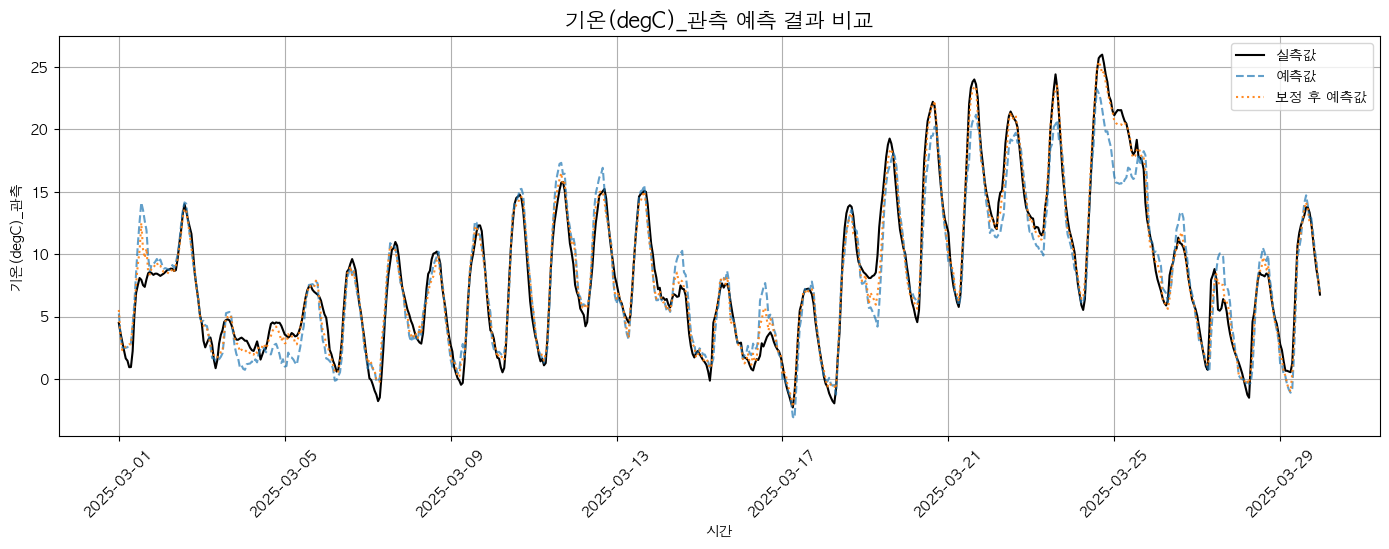

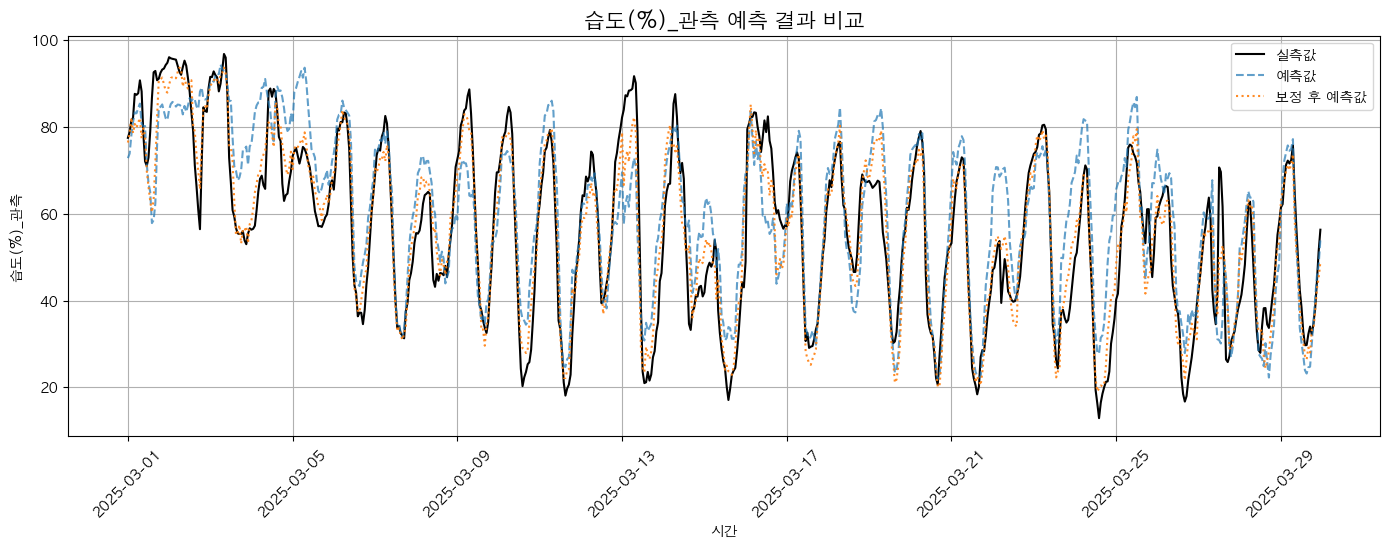

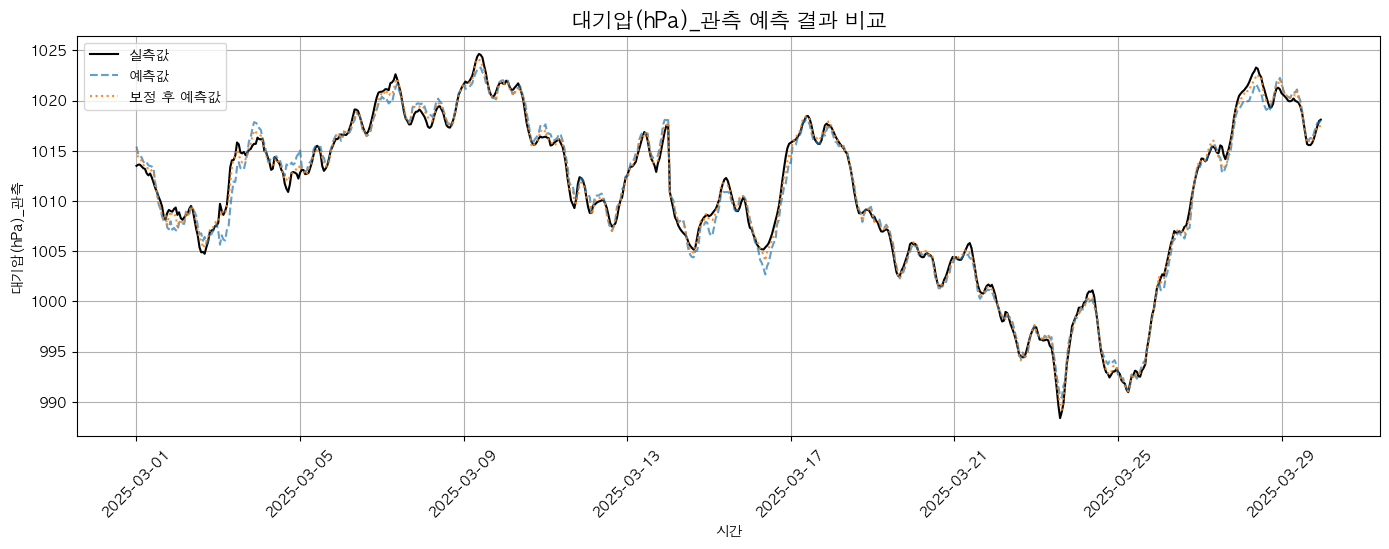

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_results_aligned(y_true_dict, y_pred_dict, residual_predictions, test_df, variable_names):
    for var in variable_names:
        valid_df = test_df.dropna(subset=[var])
        time_index = valid_df["기상관측일시"].iloc[:len(y_true_dict[var])]

        plt.figure(figsize=(14, 5))
        plt.plot(time_index, y_true_dict[var], label='실측값', color='black', linewidth=1.5)
        plt.plot(time_index, y_pred_dict[var], label='예측값', linestyle='--', alpha=0.7)
        plt.plot(time_index, residual_predictions[var], label='보정 후 예측값', linestyle=':', alpha=0.9)

        plt.title(f"{var} 예측 결과 비교", fontsize=15)
        plt.xlabel("시간")
        plt.ylabel(var)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

plot_results_aligned(y_true_dict, y_pred_dict, residual_predictions, test_df, [
    "기온(degC)_관측", "습도(%)_관측", "대기압(hPa)_관측"
])


In [59]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# 1. 준비
df = merged_df.copy()
df = df.sort_values("기상관측일시")
humidity = df["습도(%)_예측"].values.reshape(-1, 1)

# 2. 결측치 마스킹
nan_mask = np.isnan(humidity).flatten()
valid_mask = ~nan_mask

# 3. 스케일링
scaler = MinMaxScaler()
humidity_scaled = scaler.fit_transform(humidity)

# 4. 시퀀스 생성 함수
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        if not np.isnan(data[i]):
            seq = data[i - window_size:i]
            if not np.isnan(seq).any():
                X.append(seq)
                y.append(data[i])
    return np.array(X), np.array(y)

# 5. 학습 데이터 생성 (window=24)
window_size = 24
X, y = create_sequences(humidity_scaled.flatten(), window_size)
X = X.reshape(X.shape[0], window_size, 1)

# 6. 모델 정의 (CNN-LSTM)
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 1)),
    LSTM(64, activation='tanh'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=20, batch_size=32, verbose=1)

# 7. 결측치 보간
filled_humidity = humidity_scaled.copy().flatten()

for idx in np.where(nan_mask)[0]:
    if idx >= window_size:
        prev_seq = filled_humidity[idx - window_size:idx]
        if not np.isnan(prev_seq).any():
            pred = model.predict(prev_seq.reshape(1, window_size, 1), verbose=0)
            filled_humidity[idx] = pred[0, 0]

# 8. 역변환 및 적용
df["습도(%)_예측_CNNLSTM"] = scaler.inverse_transform(filled_humidity.reshape(-1,1)).flatten()


Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


325/325 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0201
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0015
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 7/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 8/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 9/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 10/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010
Epoch 11/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 12/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 13/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 14/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010
Epoch 15/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0011


In [67]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Input
import warnings

# 경고 메시지 무시 (FutureWarning 등)
warnings.filterwarnings('ignore', category=FutureWarning)

# --------------------------------------------------------------------------
# 0. 데이터 불러오기 및 기본 전처리
# --------------------------------------------------------------------------
print("⚙️ 0. 데이터 로드 및 기본 전처리 시작...")
observed_df = pd.read_csv('관측.csv')
forecast_df = pd.read_csv('예측.csv')

observed_df["기상관측일시"] = pd.to_datetime(observed_df["기상관측일시"])
forecast_df["기상관측일시"] = pd.to_datetime(forecast_df["기상관측일시"])

if "대기압(mmHg)" in observed_df.columns:
    observed_df["대기압(hPa)"] = observed_df["대기압(mmHg)"] * 1.33322
    observed_df.drop(columns=["대기압(mmHg)"], inplace=True)

# how='left'로 모든 예측 데이터를 보존하고, 관측 데이터가 없는 경우는 NaN으로 남김
merged_df = pd.merge(forecast_df, observed_df, on="기상관측일시", how='left', suffixes=("_예측", "_관측"))
merged_df = merged_df.sort_values("기상관측일시").reset_index(drop=True)
print("✅ 0. 데이터 로드 및 기본 전처리 완료.")
print("\n" + "="*50 + "\n")


# --------------------------------------------------------------------------
# 1. CNN-LSTM을 이용한 습도 결측치 보간 (데이터 누수 방지)
# --------------------------------------------------------------------------
print("💧 1. CNN-LSTM으로 습도 결측치 보간 시작...")

# Train/Test 분리 시점 정의
test_start_dt = pd.to_datetime("2025-03-01 00:00:00")

# 습도 보간을 위한 임시 데이터프레임 생성
humidity_df = merged_df[['기상관측일시', '습도(%)_예측']].copy()
train_humidity_df = humidity_df[humidity_df['기상관측일시'] < test_start_dt].copy()
test_humidity_df = humidity_df[humidity_df['기상관측일시'] >= test_start_dt].copy()

# 스케일러를 훈련 데이터에만 fit
scaler_humidity = MinMaxScaler()
train_humidity_df['humidity_scaled'] = scaler_humidity.fit_transform(train_humidity_df[['습도(%)_예측']])
test_humidity_df['humidity_scaled'] = scaler_humidity.transform(test_humidity_df[['습도(%)_예측']])

# 시퀀스 생성 함수
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        if not np.isnan(data[i]):
            sequence = data[i - window_size:i]
            if not np.isnan(sequence).any():
                X.append(sequence)
                y.append(data[i])
    return np.array(X), np.array(y)

window_size = 24
# 훈련 데이터로만 시퀀스 생성 및 모델 학습
X_train_seq, y_train_seq = create_sequences(train_humidity_df['humidity_scaled'].values, window_size)
X_train_seq = X_train_seq.reshape(X_train_seq.shape[0], window_size, 1)

cnn_lstm_model = Sequential([
    Input(shape=(window_size, 1)),
    Conv1D(64, kernel_size=3, activation='relu'),
    LSTM(64, activation='tanh'),
    Dense(1)
])
cnn_lstm_model.compile(optimizer='adam', loss='mse')
print("... CNN-LSTM 모델 학습 중 ...")
cnn_lstm_model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=1)

# 결측치 보간 함수
def fill_missing_values(df, model, scaler, window_size):
    df_filled = df.copy()
    humidity_scaled = df_filled['humidity_scaled'].values
    nan_indices = np.where(np.isnan(humidity_scaled))[0]

    for idx in nan_indices:
        if idx >= window_size:
            prev_seq = humidity_scaled[idx - window_size:idx]
            if not np.isnan(prev_seq).any():
                pred_scaled = model.predict(prev_seq.reshape(1, window_size, 1), verbose=0)
                humidity_scaled[idx] = pred_scaled[0, 0]
    
    # [수정] 권장 방식인 ffill(), bfill() 사용
    df_filled['humidity_scaled'] = pd.Series(humidity_scaled).ffill().bfill()
    df_filled["습도(%)_예측_보간"] = scaler.inverse_transform(df_filled[['humidity_scaled']]).flatten()
    return df_filled

# 훈련 및 테스트 데이터 각각 보간 수행
train_humidity_df = fill_missing_values(train_humidity_df, cnn_lstm_model, scaler_humidity, window_size)
test_humidity_df = fill_missing_values(test_humidity_df, cnn_lstm_model, scaler_humidity, window_size)

# 보간된 습도 값을 원래의 merged_df에 업데이트
merged_df['습도(%)_예측'] = pd.concat([train_humidity_df['습도(%)_예측_보간'], test_humidity_df['습도(%)_예측_보간']], ignore_index=True)

print("✅ 1. CNN-LSTM 보간 완료.")
print("\n" + "="*50 + "\n")


# --------------------------------------------------------------------------
# 2. XGBoost 모델링을 위한 전처리 및 피처 엔지니어링
# --------------------------------------------------------------------------
print("🚀 2. XGBoost 모델 학습 및 평가 시작...")

# 시간 관련 파생변수 생성
merged_df["hour"] = merged_df["기상관측일시"].dt.hour
merged_df["month"] = merged_df["기상관측일시"].dt.month
merged_df["dayofweek"] = merged_df["기상관측일시"].dt.dayofweek
merged_df["is_weekend"] = merged_df["dayofweek"].isin([5, 6]).astype(int)
merged_df["is_night"] = merged_df["hour"].isin([0, 1, 2, 3, 4, 5]).astype(int)

# Train/Test 분리
train_df = merged_df[merged_df["기상관측일시"] < test_start_dt].copy()
test_df = merged_df[merged_df["기상관측일시"] >= test_start_dt].copy()

# 보간 및 피처 엔지니어링 함수
def impute_and_feature_engineer(train_df, test_df, n_neighbors=3):
    train_df_out, test_df_out = train_df.copy(), test_df.copy()
    numeric_cols_to_impute = ["기온(degC)_예측", "대기압(hPa)_예측", "일사량(w/m^2)"]
    
    scaler = StandardScaler()
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
    
    train_df_out[numeric_cols_to_impute] = imputer.fit_transform(scaler.fit_transform(train_df_out[numeric_cols_to_impute]))
    train_df_out[numeric_cols_to_impute] = scaler.inverse_transform(train_df_out[numeric_cols_to_impute])
    
    test_df_out[numeric_cols_to_impute] = imputer.transform(scaler.transform(test_df_out[numeric_cols_to_impute]))
    test_df_out[numeric_cols_to_impute] = scaler.inverse_transform(test_df_out[numeric_cols_to_impute])
    
    processed_dfs = []
    for df in [train_df_out, test_df_out]:
        df["일사량(w/m^2)"] = df["일사량(w/m^2)"].clip(lower=0)
        df.loc[df["hour"].isin([0, 1, 2, 3, 4, 5]), "일사량(w/m^2)"] = 0
        T, RH = df["기온(degC)_예측"], df["습도(%)_예측"]
        df["절대습도"] = (6.112 * np.exp((17.67 * T) / (T + 243.5)) * RH * 2.1674 / (273.15 + T)).clip(lower=0)
        df["기온_diff_t1"] = df["기온(degC)_예측"].diff()
        df["습도_diff_t1"] = df["습도(%)_예측"].diff()
        df["기온_rollmean_24"] = df["기온(degC)_예측"].rolling(window=24, min_periods=1).mean()
        df["습도_rollstd_24"] = df["습도(%)_예측"].rolling(window=24, min_periods=1).std()
        df["기온x습도"] = df["기온(degC)_예측"] * df["습도(%)_예측"]
        df["기온x대기압"] = df["기온(degC)_예측"] * df["대기압(hPa)_예측"]
        for col in ["기온(degC)_예측", "습도(%)_예측", "절대습도"]:
            df[f"{col}_t-1"] = df[col].shift(1)
            df[f"{col}_t-24"] = df[col].shift(24)
        processed_dfs.append(df)
    return processed_dfs[0], processed_dfs[1]

train_df, test_df = impute_and_feature_engineer(train_df, test_df)

# --------------------------------------------------------------------------
# 3. XGBoost 모델 학습 및 평가
# --------------------------------------------------------------------------
target_cols = [
    ("기온(degC)_예측", "기온(degC)_관측"),
    ("습도(%)_예측", "습도(%)_관측"),
    ("대기압(hPa)_예측", "대기압(hPa)_관측")
]
feature_cols = [
    "기온(degC)_예측", "습도(%)_예측", "대기압(hPa)_예측", "절대습도", "일사량(w/m^2)",
    "hour", "month", "dayofweek", "is_weekend", "is_night", "기온(degC)_예측_t-1",
    "기온(degC)_예측_t-24", "습도(%)_예측_t-1", "습도(%)_예측_t-24", "절대습도_t-1",
    "절대습도_t-24", "기온_diff_t1", "습도_diff_t1", "기온_rollmean_24",
    "습도_rollstd_24", "기온x습도", "기온x대기압"
]
best_params_dict = {
    "기온(degC)_관측": {'n_estimators': 345, 'max_depth': 10, 'learning_rate': 0.06366, 'subsample': 0.6792, 'colsample_bytree': 0.9433, 'gamma': 0.0680, 'min_child_weight': 6},
    "습도(%)_관측": {'n_estimators': 472, 'max_depth': 10, 'learning_rate': 0.0408, 'subsample': 0.6613, 'colsample_bytree': 0.8895, 'gamma': 0.6586, 'min_child_weight': 2},
    "대기압(hPa)_관측": {'n_estimators': 206, 'max_depth': 10, 'learning_rate': 0.0988, 'subsample': 0.9600, 'colsample_bytree': 0.9061, 'gamma': 0.0399, 'min_child_weight': 3}
}

# 루프 시작 전 결측치 한 번에 제거
all_target_cols = [col[1] for col in target_cols]
train_df_cleaned = train_df.dropna(subset=feature_cols + all_target_cols).copy()
test_df_cleaned = test_df.dropna(subset=feature_cols + all_target_cols).copy()

models = {}
y_true_dict = {}
y_pred_dict = {}

for pred_col, true_col in target_cols:
    X_train, y_train = train_df_cleaned[feature_cols], train_df_cleaned[true_col]
    X_test, y_test = test_df_cleaned[feature_cols], test_df_cleaned[true_col]

    model = xgb.XGBRegressor(**best_params_dict[true_col], random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    models[true_col] = model
    y_true_dict[true_col] = y_test
    y_pred_dict[true_col] = pd.Series(y_pred, index=y_test.index)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"📌 [기본] {true_col} | MAE: {mae:.4f}, RMSE: {rmse:.4f}")

def sAError(y_true, y_pred):
    weights = {"기온(degC)_관측": 0.5, "습도(%)_관측": 0.3, "대기압(hPa)_관측": 0.2}
    s_rmse = sum(w * np.sqrt(mean_squared_error(y_true[c], y_pred[c])) for c, w in weights.items())
    s_mae = sum(w * mean_absolute_error(y_true[c], y_pred[c]) for c, w in weights.items())
    return (s_rmse + s_mae) / 2

print(f"\n🌟 [기본] 최종 sAError: {sAError(y_true_dict, y_pred_dict):.4f}")
print("\n" + "="*50 + "\n")


# --------------------------------------------------------------------------
# 4. 잔차(Residual) 보정 모델 적용
# --------------------------------------------------------------------------
print("📈 Residual Correction Results (Corrected Method)")
y_pred_corrected_dict = {}

for pred_col, true_col in target_cols:
    X_train, y_train_true = train_df_cleaned[feature_cols], train_df_cleaned[true_col]
    X_test, y_test_true = test_df_cleaned[feature_cols], test_df_cleaned[true_col]
    
    y_train_pred = models[true_col].predict(X_train)
    train_residuals = y_train_true - y_train_pred

    res_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, random_state=42, n_jobs=-1)
    res_model.fit(X_train, train_residuals)
    
    y_base_pred = y_pred_dict[true_col]
    residual_pred_on_test = res_model.predict(X_test)
    y_corrected = y_base_pred + residual_pred_on_test
    
    y_pred_corrected_dict[true_col] = pd.Series(y_corrected, index=y_test_true.index)
    
    mae = mean_absolute_error(y_test_true, y_corrected)
    rmse = np.sqrt(mean_squared_error(y_test_true, y_corrected))
    print(f"📌 [보정] {true_col} | MAE: {mae:.4f}, RMSE: {rmse:.4f}")

print(f"\n🌟 [보정] 최종 sAError: {sAError(y_true_dict, y_pred_corrected_dict):.4f}")

⚙️ 0. 데이터 로드 및 기본 전처리 시작...
✅ 0. 데이터 로드 및 기본 전처리 완료.


💧 1. CNN-LSTM으로 습도 결측치 보간 시작...
... CNN-LSTM 모델 학습 중 ...
Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0273
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0017
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0012
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010 
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 9/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010
Epoch 10/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011
Epoch 11/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010   
Epoch 12/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0010
Epoch 13/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0010
Epoch 14/

ValueError: Data must be 1-dimensional, got ndarray of shape (0, 0) instead

In [72]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. 데이터 불러오기 및 전처리
df = pd.read_csv("공모전_data.csv")
df = df.dropna()

X = df[["예측_일사량", "예측_습도", "예측_절대습도", "예측_기온", "예측_대기압", "월", "일", "시"]]
y = df["관측_기온"]

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 앙상블 모델 구성
base_models = [
    ("rf", RandomForestRegressor(n_estimators=100, random_state=42)),
    ("xgb", XGBRegressor(n_estimators=100, random_state=42, verbosity=0)),
    ("lgbm", LGBMRegressor(n_estimators=100, random_state=42))
]

meta_model = RidgeCV()

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True,
    cv=5
)

# 4. 학습 및 예측
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

# 5. 성능 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"✅ Stacking 성능 (관측_기온 예측)")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")


ValueError: The estimator XGBRegressor should be a regressor.